## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import copy
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import moment

# Pytorch
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sklearn
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px
import os
os.chdir("/home/rodrigo/mount/home/rodrigo/git/neural_kaggle_store_item")

import joypy
import time
import math
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from transformer.model import TransformerTimeSeries
from transformer.utils import TransformerSet, batch_train, batch_val
import seaborn as sns
np.random.seed(0)


In [2]:
os.getcwd()

'/home/rodrigo/mount/home/rodrigo/git/neural_kaggle_store_item'

## Generate train and test sets
For a simple example lets generate sinusoid data to test with

In [3]:
data_train = pd.read_csv('train_series.csv')
data_train = data_train['data'].to_numpy()

data_val = pd.read_csv('val_series.csv')
data_val = data_val['data'].to_numpy()

total_train = len(data_train)

data_test = pd.read_csv('test_series.csv')
data_test = data_test['data'].to_numpy()

In [4]:
data_train

array([ 0.        ,  0.08618457,  0.17172779, ..., -0.90355999,
       -0.93712479, -0.96371586])

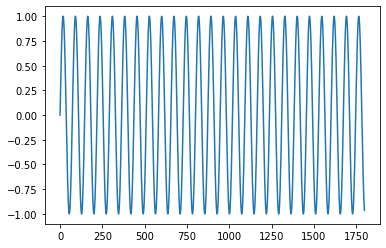

In [5]:
plt.plot(data_train)

## Rolling window approach

With this approach is possible to turn a series of data into a supervised learning problem, this way the model can intepretate the problem properly.

In [6]:
# Scaling the entry data
data_train   = data_train.reshape(-1,1)
# scaler        = StandardScaler()
scaler        = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)

data_train = scaler.transform(data_train).flatten()
data_val   = scaler.transform(data_val.reshape(-1,1)).flatten()
index_val  = np.arange(len(data_train))


pred_horizon = 30
label_win = 30
feat_win  = 30
win_size  = label_win + feat_win 
n_windows = total_train - win_size

In [7]:
def rolling_window(n_windows, feat_win, label_win, dataset):
    x_train = np.zeros((n_windows, int(feat_win + label_win)))
    x_id = np.zeros((n_windows, int(feat_win + label_win)))
    y_train = np.zeros((n_windows, feat_win + label_win))
    y_id = np.zeros((n_windows, feat_win + label_win))
    for win in range(n_windows):
        # Feature window start and end index
        i_s = win
        i_e = win + feat_win + label_win

        # Geting the past sales feature
        x_train[win][:feat_win] = dataset[i_s: i_e-label_win]
        x_id[win][:feat_win] = index_val[i_s: i_e-label_win]

        # Geting the weekdays feature
        # x_train[win][feat_win:] = weekday_train[i_s_label : i_e_label]

        # Since we want the weekdays to be corralated to the label values
        # the window of weekdays value that we will use will be the label's
        # weekday. This makes sense taking in count that we know the weekdays
        # beforehand

        # Geting the labels
        y_train[win] = data_train[i_s : i_e]
        y_id[win] = index_val[i_s : i_e]
    
    return x_train, x_id, y_train, y_id

In [8]:
x_train, x_id, y_train, y_id = rolling_window(n_windows, feat_win, label_win, data_train)

n_val_windows = len(data_val) - win_size
x_val, x_val_id, y_val, y_val_id= rolling_window(n_val_windows, feat_win, label_win, data_val)

In [9]:
y_id[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59.])

In [10]:
x_id[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

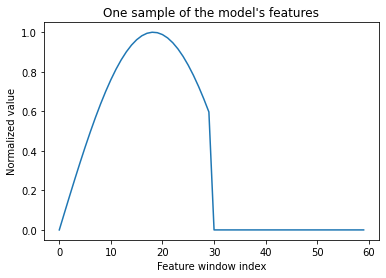

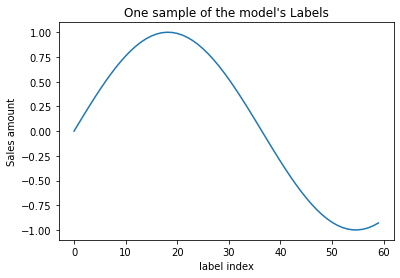

In [11]:
plt.plot(x_train[0], label='features')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of the model's features")
plt.show()

plt.plot(y_train[0], label='labels')
plt.ylabel('Sales amount')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()


## Defining the model
The recommended neural network for a time series problem usualy is a LSTM, in this example peharps we will use a simple multi layer perceptron (MLP) model.

In [12]:
data_test   = data_test.reshape(-1,1)
data_test   = scaler.transform(data_test).flatten()

entry_test = np.zeros(int(feat_win+label_win))
entry_test[:feat_win] = data_val[-feat_win:]
entry_test[feat_win:] = data_test[:label_win]

label_test = copy.deepcopy(entry_test)
entry_test[feat_win:] = 0

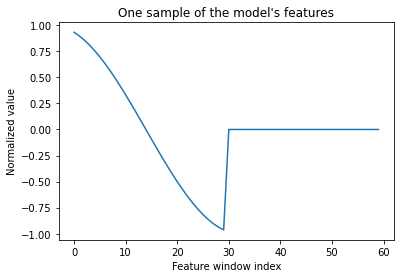

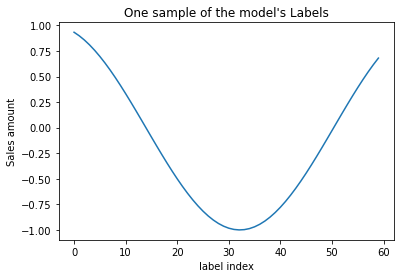

In [13]:
plt.plot(entry_test, label='features')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of the model's features")
plt.show()

plt.plot(label_test, label='labels')
plt.ylabel('Sales amount')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()

## Transformer network

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = TransformerTimeSeries(device, dropout=0, d_model=64, 
                              encoder_mask=True, 
                              nhead=4, 
                              encoder_only=True,
                              output_vector_sz=1,
                              iterative=False,
                              n_encoder_time_steps=feat_win+label_win,
                              n_input_time_steps=feat_win,
                              n_enc_layers=1
                             ).to(device)

criterion = nn.MSELoss()
lr = 0.0005
batch_size= 60
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

Using device: cuda


In [15]:
x_train.shape[1]

60

In [16]:
train_set = TransformerSet(x_train, y_train, x_train.shape[1], encoder_only=True)
val_set = TransformerSet(x_val, y_val, x_val.shape[1], encoder_only=True)
test_set  = TransformerSet(np.array([entry_test]),np.array([label_test]), x_train.shape[1], encoder_only=True)

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_set,
                          batch_size=batch_size,
                          shuffle=False)

In [17]:
loss = []
val_loss = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    epoch_loss = batch_train(model, epoch, batch_size, train_loader, criterion, optimizer, scheduler,  
                             y_train.shape[0], 
                             device, encoder_only=True, 
                             informer_pred_sz=label_win)
    val_epoch_loss = batch_val(model, val_loader, 
                               criterion, device, 
                               encoder_only=True, 
                               informer_pred_sz=label_win) 
    loss.append(epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step()


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     5/   29 batches | lr 0.000500 | 33.22 ms | loss 0.96969
| epoch   1 |    10/   29 batches | lr 0.000500 | 23.34 ms | loss 0.50990
| epoch   1 |    15/   29 batches | lr 0.000500 | 22.99 ms | loss 0.35983
| epoch   1 |    20/   29 batches | lr 0.000500 | 23.01 ms | loss 0.35574
| epoch   1 |    25/   29 batches | lr 0.000500 | 23.47 ms | loss 0.28867
| epoch   2 |     5/   29 batches | lr 0.000480 | 27.59 ms | loss 0.27062
| epoch   2 |    10/   29 batches | lr 0.000480 | 24.26 ms | loss 0.19275
| epoch   2 |    15/   29 batches | lr 0.000480 | 23.94 ms | loss 0.17785
| epoch   2 |    20/   29 batches | lr 0.000480 | 24.76 ms | loss 0.16068
| epoch   2 |    25/   29 batches | lr 0.000480 | 24.24 ms | loss 0.16133
| epoch   3 |     5/   29 batches | lr 0.000471 | 32.97 ms | loss 0.18237
| epoch   3 |    10/   29 batches | lr 0.000471 | 30.10 ms | loss 0.12790
| epoch   3 |    15/   29 batches | lr 0.000471 | 29.65 ms | loss 0.11029
| epoch   3 |    20/   29 batches | lr

In [18]:
plot_df ={'loss': loss,
          'val_loss': val_loss,
         'epochs': np.arange(len(loss))}

fig = px.line(plot_df, x='epochs', y=['loss', 'val_loss'])
fig.show()

In [19]:
src, true_target = next(iter(train_loader))
src = Variable(torch.Tensor(src.float())).to(device)

output = model(src)
output.shape

torch.Size([60, 60])

In [20]:
true_target.shape

torch.Size([60, 60])

In [21]:
model.eval()
src, true_target = next(iter(test_loader))
src = Variable(torch.Tensor(src.float())).to(device)
output     = model(src).cpu().view(-1)
output = output.detach().numpy().reshape(len(output),1)
output = scaler.inverse_transform(output).flatten()

In [22]:
label_test = true_target.cpu().view(-1).detach().numpy()
label_test = label_test.reshape(len(label_test),1)
label_test = scaler.inverse_transform(label_test).flatten()

In [23]:
output.shape

(60,)

In [24]:
plot_df ={'prediction_index': np.arange(pred_horizon),
          'pred': output[-pred_horizon:],
          'label': label_test[-pred_horizon:],
          'error': output[-pred_horizon:]-label_test[-pred_horizon:]}

fig = px.line(plot_df, x='prediction_index', y=['pred','label','error'])
fig.show()

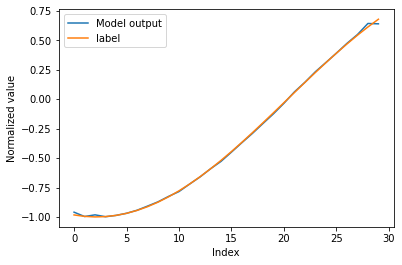

In [25]:
plt.plot(output[-pred_horizon:], label='Model output')
plt.plot(label_test[-pred_horizon:], label='label')


plt.ylabel('Normalized value')
plt.xlabel('Index')
plt.legend()
plt.show()

In [26]:
mean_squared_error(label_test[-pred_horizon:], output[-pred_horizon:])

0.00012576463909628297

In [27]:
attention_weights = model.encoder_attention(src, layer_idx=0)[1]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights = attention_weights.reshape(src.shape[1], src.shape[1])

In [28]:
# attention_weights = attention_weights[feat_win:, :feat_win]

In [29]:
attention_weights.shape

(60, 60)

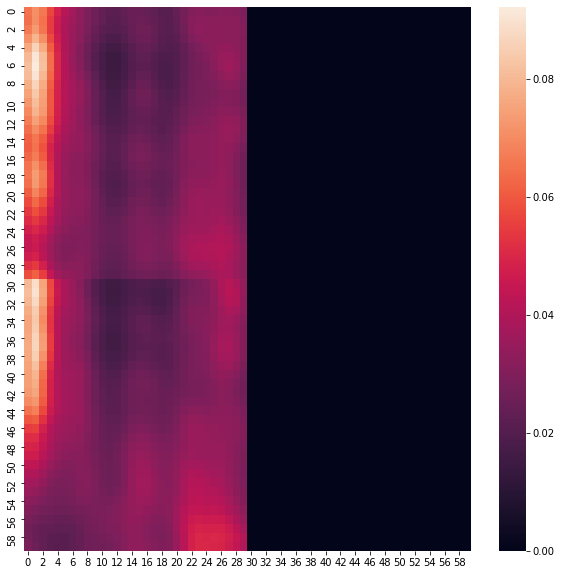

In [30]:
import seaborn as sns
plt.figure(figsize=(10, 10))
ax = sns.heatmap(attention_weights)

In [31]:
df = {'row_idx':[],
      'col_idx':[],
      'value':[]}
for row_idx in range(attention_weights.shape[0]):
    for col_idx in range(attention_weights.shape[1]):
        df['row_idx'].append(row_idx)
        df['col_idx'].append(col_idx)
        df['value'].append(attention_weights[row_idx][col_idx])

In [32]:
# df['col'] = np.arange(attention_weights.shape[1])
df = pd.DataFrame(df)

<ipython-input-33-04e6380d6e0d>:14: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



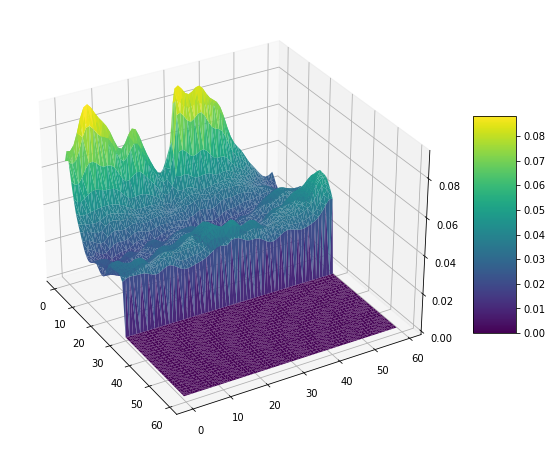

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

 
# Transform it to a long format
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# to Add a color bar which maps values to colors.
fig = plt.figure(figsize=(11, 8))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, -30)
plt.show()